# Ungraded Lab: CelebA GAN Experiments

This lab will demonstrate a GAN trained on the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. This is a resource-intensive task so you will use a TPU and a distributed strategy to train the network. It will take 40 to 50 minutes to run the entire exercise. Afterwards, you will see a gif showing new faces generated by the trained model.

## Imports

In [1]:
# install tensorflow_addons
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
import zipfile
import glob
import urllib.request
from enum import Enum
from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from IPython.display import display
from IPython.display import Image as IpyImage
import imageio
import cv2

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Setup TPU

You will use a TPU and its corresponding [distribution strategy](https://www.tensorflow.org/api_docs/python/tf/distribute/TPUStrategy) to speed up the training. We've provided the setup code and helper functions below. You might recognize some of these from taking Course 2 of this Specialization.

In [4]:
tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
strategy = tf.distribute.TPUStrategy(tpu_cluster_resolver)

In [5]:
class Reduction(Enum):
    NONE = 0
    SUM = 1
    MEAN = 2
    CONCAT = 3

def distributed(*reduction_flags):
    def _decorator(fun):
        def per_replica_reduction(z, flag):
            if flag == Reduction.NONE:
                return z
            elif flag == Reduction.SUM:
                return strategy.reduce(tf.distribute.ReduceOp.SUM, z, axis=None)
            elif flag == Reduction.MEAN:
                return strategy.reduce(tf.distribute.ReduceOp.MEAN, z, axis=None)
            elif flag == Reduction.CONCAT:
                z_list = strategy.experimental_local_results(z)
                return tf.concat(z_list, axis=0)
            else:
                raise NotImplementedError()

        @tf.function
        def _decorated_fun(*args, **kwargs):
            fun_result = strategy.run(fun, args=args, kwargs=kwargs)
            if len(reduction_flags) == 0:
                assert fun_result is None
                return
            elif len(reduction_flags) == 1:
                assert type(fun_result) is not tuple and fun_redult is not None
                return per_replica_reduction(fun_result, *reduction_flags)
            else:
                assert type(fun_result) is tuple
                return tuple((per_replica_reduction(fr, rf) for fr, rf in zip(fun_result, reduction_flags)))
        return _decorated_fun
    return _decorator

## Download and Prepare the Dataset

Next, you will fetch the celebrity faces dataset. We've hosted a copy of the data in a Google Drive but the filesize is around 1GB so it will take some time to download.

In [6]:
# make a data directory
try:
  os.mkdir('/tmp/celeb')
except OSError:
  pass

# download the dataset archive
data_url = "https://storage.googleapis.com/learning-datasets/Resources/archive.zip"
data_file_name = "archive.zip"
download_dir = '/tmp/celeb/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zipped file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

You will then prepare the dataset. Preprocessing steps include cropping and transforming the pixel values to the range `[-1, 1]`. Training batches are then prepared so it can be fed into the model later.

In [7]:
def load_celeba(batch_size, resize=64, crop_size=128):
  """Creates batches of preprocessed images from the JPG files
  Args:
    batch_size - batch size
    resize - size in pixels to resize the images
    crop_size - size to crop from the image

  Returns:
    prepared dataset
  """
  # initialize zero-filled array equal to the size of the dataset
  image_paths = sorted(glob.glob("/tmp/celeb/img_align_celeba/img_align_celeba/*.jpg"))
  images = np.zeros((len(image_paths), resize, resize, 3), np.uint8)
  print("Creating Images")

  # crop and resize the raw images then put into the array
  for i, path in tqdm(enumerate(image_paths)):
    with Image.open(path) as img:
      left = (img.size[0] - crop_size) // 2
      top = (img.size[1] - crop_size) // 2
      right = left + crop_size
      bottom = top + crop_size
      img = img.crop((left, top, right, bottom))
      img = img.resize((resize, resize), Image.LANCZOS)
      images[i] = np.asarray(img, np.uint8)

  # split the images array into two
  split_n = images.shape[0] // 2
  images1, images2 = images[:split_n], images[split_n:2 * split_n]
  del images

  # preprocessing function to convert the pixel values into the range [-1,1]
  def preprocess(img):
      x = tf.cast(img, tf.float32) / 127.5 - 1.0
      return x

  # use the preprocessing function on the arrays and create batches
  dataset = tf.data.Dataset.from_tensor_slices((images1, images2))
  dataset = dataset.map(
      lambda x1, x2: (preprocess(x1), preprocess(x2))
  ).shuffle(4096).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

# use the function above to load and prepare the dataset
batch_size = 8
batch_size = batch_size * strategy.num_replicas_in_sync
dataset = load_celeba(batch_size)
out_dir = "celeba_out"

Creating Images


202599it [04:19, 780.57it/s]


## Build the Model

Next, you will build the generator and discriminator. As mentioned in the lecture, the code in this notebook is generalized to make it easy to reconfigure (such as choosing the type of normalization). With that, you will notice a lot of extra code, mostly related to gradient penalty. You can ignore those and we've set the defaults to the reflect the architecture shown in class.

You can try the other settings once you've gone through these defaults. Additional modes made available are based on DRAGAN and WGAN-GP and you can read about it [here](https://arxiv.org/abs/1705.07215) and [here](https://arxiv.org/abs/1704.00028v3). These settings are reconfigured using the utilities below.

In [8]:
# Utilities

def _get_norm_layer(norm):
    if norm == 'NA':
        return lambda: lambda x: x
    elif norm == 'batch_normalization':
        return layers.BatchNormalization
    elif norm == 'instance_normaliation':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_normalization':
        return layers.LayerNormalization


def get_initializers():
    return (tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), # conv initializer
            tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.02)) # bn gamma initializer


def gradient_penalty(f, real, fake, mode):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp

    if mode == 'none':
        gp = tf.constant(0, dtype=real.dtype)
    elif mode == 'dragan':
        gp = _gradient_penalty(f, real)
    elif mode == 'wgan-gp':
        gp = _gradient_penalty(f, real, fake)

    return gp

### Generator

You will first define the generator layers. Again, you will notice some extra code but the default will follow the architecture in class. Like the DCGAN you previously built, the model here primarily uses blocks containing Conv2D, BatchNormalization, and ReLU layers.

In [9]:
def create_generator(input_shape=(1, 1, 128),
                    output_channels=3,
                    dim=64,
                    n_upsamplings=4,
                    norm='batch_normalization',
                    name='generator'):

    Normalization = _get_norm_layer(norm)
    conv_initializer, bn_gamma_initializer = get_initializers()

    # 0
    x = inputs = tf.keras.Input(shape=input_shape)

    # 1: 1x1 -> 4x4
    dimensions = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    x = layers.Conv2DTranspose(
        dimensions, 4, strides=1, padding='valid', use_bias=False,
        # kernel_initializer=conv_initializer
    )(x)
    x = Normalization(
        # gamma_initializer=bn_gamma_initializer
        )(x)
    x = layers.ReLU()(x)

    # 2: upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        dimensions = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        x = layers.Conv2DTranspose(
            dimensions, 4, strides=2, padding='same', use_bias=False,
            # kernel_initializer=conv_initializer
            )(x)
        x = Normalization(
            # gamma_initializer=bn_gamma_initializer
            )(x)
        x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(
        output_channels, 4, strides=2, padding='same',
        # kernel_initializer=conv_initializer
    )(x)

    outputs = layers.Activation('tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

### Discriminator

The discriminator will use strided convolutions to reduce the dimensionality of the features. These will be connected to a [LeakyReLU](https://keras.io/api/layers/activation_layers/leaky_relu/) activation.

In [10]:
def create_discriminator(input_shape=(64, 64, 3),
                        dim=64,
                        n_downsamplings=4,
                        norm='batch_normalization',
                        name='discriminator'):
    Normalization = _get_norm_layer(norm)
    conv_initializer, bn_gamma_initializer = get_initializers()

    # 0
    x = inputs = tf.keras.Input(shape=input_shape)

    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    x = layers.Conv2D(dim, 4, strides=2, padding='same',
                      # kernel_initializer=conv_initializer
                      )(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    for i in range(n_downsamplings - 1):
        dimensions = min(dim * 2 ** (i + 1), dim * 8)
        x = layers.Conv2D(dimensions, 4, strides=2, padding='same', use_bias=False,
                          # kernel_initializer=conv_initializer
                          )(x)
        x = Normalization(
            # gamma_initializer=bn_gamma_initializer
            )(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    # 2: logit
    outputs = layers.Conv2D(1, 4, strides=1, padding='valid',
                            # kernel_initializer=conv_initializer
                            )(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

With the layers for the generator and discriminator defined, you can now create the models and set it up for training.

In [11]:
# Settings
resize = 64
shape = (resize, resize, 3)
z_dim = 128
n_G_upsamplings = n_D_downsamplings = 4
gradient_penalty_mode = 'none'

if gradient_penalty_mode == 'none':
  d_norm = 'batch_normalization'
elif gradient_penalty_mode in ['dragan', 'wgan-gp']:
  # Avoid using BN with GP
  d_norm = 'layer_normalization'
gradient_penalty_weight = 10.0


# Build the GAN
with strategy.scope():
    # create the generator model
    model_G = create_generator(input_shape=(1, 1, z_dim), output_channels=shape[-1], n_upsamplings=n_G_upsamplings)

    # create the discriminator model
    model_D = create_discriminator(input_shape=shape, n_downsamplings=n_D_downsamplings, norm=d_norm)

    # print summaries
    model_G.summary()
    model_D.summary()

    # set optimizers
    param_G = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    param_D = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

    # create distributed dataset
    dataset = strategy.experimental_distribute_dataset(dataset)

    # set the loss function
    loss_func = tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE
    )

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097152   
 ranspose)                                                       
                                                         

## Training

Finally, you can now train the model. We've provided some helper functions for visualizing and saving the images per epoch.

In [12]:
# Utilities

def make_grid(imgs, nrow, padding=0):
    assert imgs.ndim == 4 and nrow > 0

    batch, height, width, ch = imgs.shape
    n = nrow * (batch // nrow + np.sign(batch % nrow))
    ncol = n // nrow
    pad = np.zeros((n - batch, height, width, ch), imgs.dtype)
    x = np.concatenate([imgs, pad], axis=0)

    # border padding if required
    if padding > 0:
        x = np.pad(x, ((0, 0), (0, padding), (0, padding), (0, 0)),
                   "constant", constant_values=(0, 0))
        height += padding
        width += padding

    x = x.reshape(ncol, nrow, height, width, ch)
    x = x.transpose([0, 2, 1, 3, 4])  # (ncol, height, nrow, width, ch)
    x = x.reshape(height * ncol, width * nrow, ch)

    if padding > 0:
        x = x[:(height * ncol - padding),:(width * nrow - padding),:]
    return x

def save_img(imgs, filepath, nrow, padding=0):
    grid_img = make_grid(imgs, nrow, padding=padding)
    grid_img = ((grid_img + 1.0) * 127.5).astype(np.uint8)
    with Image.fromarray(grid_img) as img:
        img.save(filepath)

This function defines the training on a given batch. It does the two-phase training discussed in class.
* First, you train the discriminator to distinguish between fake and real images.
* Next, you train the generator to create fake images that will fool the discriminator.

In [13]:
@distributed(Reduction.SUM, Reduction.SUM, Reduction.CONCAT)
def train_on_batch(real_img1, real_img2):
    '''trains the GAN on a given batch'''
    # concatenate the real image inputs
    real_img = tf.concat([real_img1, real_img2], axis=0)

    # PHASE ONE - train the discriminator
    with tf.GradientTape() as d_tape:

        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))

        # generate fake images
        fake_img = model_G(z)

        # feed the fake images to the discriminator
        fake_out = model_D(fake_img)

        # feed the real images to the discriminator
        real_out = model_D(real_img)

        # use the loss function to measure how well the discriminator
        # labels fake or real images
        d_fake_loss = loss_func(tf.zeros_like(fake_out), fake_out)
        d_real_loss = loss_func(tf.ones_like(real_out), real_out)

        # get the total loss
        d_loss = (d_fake_loss + d_real_loss)
        d_loss = tf.reduce_sum(d_loss) / (batch_size * 2)

        # Gradient Penalty (ignore if you set mode to `none`)
        gp = gradient_penalty(partial(model_D, training=True), real_img, fake_img, mode=gradient_penalty_mode)
        gp = gp  / (batch_size * 2)
        d_loss = d_loss + gp * gradient_penalty_weight

    # get the gradients
    gradients = d_tape.gradient(d_loss, model_D.trainable_variables)

    # update the weights of the discriminator
    param_D.apply_gradients(zip(gradients, model_D.trainable_variables))


    # PHASE TWO - train the generator
    with tf.GradientTape() as g_tape:
        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))

        # generate fake images
        fake_img = model_G(z)

        # feed fake images to the discriminator
        fake_out = model_D(fake_img)

        # use loss function to measure how well the generator
        # is able to trick the discriminator (i.e. model_D should output 1's)
        g_loss = loss_func(tf.ones_like(fake_out), fake_out)
        g_loss = tf.reduce_sum(g_loss) / (batch_size * 2)

    # get the gradients
    gradients = g_tape.gradient(g_loss, model_G.trainable_variables)

    # update the weights of the generator
    param_G.apply_gradients(zip(gradients, model_G.trainable_variables))

    # return the losses and fake images for monitoring
    return d_loss, g_loss, fake_img

This will start the training loop. We set the number of epochs but feel free to revise it. From initial runs, it takes around 50 seconds to complete 1 epoch. We've setup a progress bar to display the losses per epoch and there is code as well to print the fake images generated.

In [14]:
# generate a batch of noisy input
test_z = tf.random.normal(shape=(64, 1, 1, z_dim))

# start loop
for epoch in range(30):
    with tqdm(dataset) as pbar:
        pbar.set_description(f"[Epoch {epoch}]")
        for step, (X1, X2) in enumerate(pbar):
            # train on the current batch
            d_loss, g_loss, fake = train_on_batch(X1, X2)

            # display the losses
            pbar.set_postfix({"g_loss": g_loss.numpy(), "d_loss": d_loss.numpy()})

        # generate fake images
        fake_img = model_G(test_z)

    # save output
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    file_path = out_dir+f"/epoch_{epoch:04}.png"
    save_img(fake_img.numpy()[:64], file_path, 8)

    # display gallery of fake faces
    if epoch % 1 == 0:
        with Image.open(file_path) as img:
            plt.imshow(np.asarray(img))
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Display GIF sample results

You can run the cells below to display the galleries as an animation.

In [15]:
imgs = os.listdir('celeba_out')
imgs.sort()
imgs = [cv2.imread('celeba_out/' + i) for i in imgs]
imgs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in imgs]
imageio.mimsave('anim.gif', imgs, fps=2)

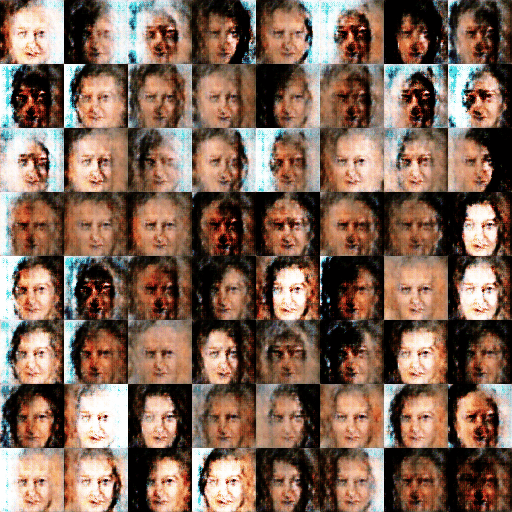

In [16]:
path="anim.gif"

with open(path,'rb') as f:
    display(IpyImage(data=f.read(), format='png'))

**Congratulations on completing the final ungraded lab for this course!**